In [36]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from market import IntegratedMarketModel

In [37]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [43]:
n_firms = 10 
n_consumers = 10000
n_chars = 2
T = 100
# approximately the model at true parameters and at the estimation value of the parameters 

# values from sigma and mu retrived from the wolfram calculator
# From the RCL 
# sigma_hat = 0.15357
# mu_hat = 0.485399
# beta1_hat = 2.024542
# beta2_hat = -0.301386
# beta3_hat = -0.301354

# # From the BLP 
# sigma_hat = 0.161339
# mu_hat = 0.525552
# beta1_hat = 2.175444
# beta2_hat = -0.301979
# beta3_hat = -0.301941

# # True 
sigma_hat = 0.2
mu_hat = 0.5
beta1_hat = 2.
beta2_hat = -0.3
beta3_hat = -0.3





# for the production function estimation 
# theta_l_hat = .6000834 
# From the ACF method
theta_l_hat = 0.600012
wage_hat = 15

In [44]:
# Instead of this it can also be posibile to just plug in the model estimation from seed 100 directly from 
# the created datasets
seed = 4
df= pd.read_csv(f'../data/market_integrates_{seed}.csv')
print(df)


model_true = IntegratedMarketModel(
        n_firms, 
        n_consumers, 
        n_chars, 
        T, 
        seed=seed
    )
model_true.demand_side_optimisation()


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         4.582194         1.697368  4.572060   
1             1         2         4.904177         3.831666  4.295544   
2             1         3         1.272172         3.596674  4.809153   
3             1         4         4.533492         1.943444  4.598940   
4             1         5         3.396054         4.213493  4.469387   
..          ...       ...              ...              ...       ...   
995         100         6         1.712343         4.454706  4.589379   
996         100         7         3.032257         5.808905  4.213014   
997         100         8         5.301537         5.261936  3.829661   
998         100         9         4.131692         5.935763  4.236585   
999         100        10         2.749951         5.557247  4.592509   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         3.793774  0.001272  0.000990  1.205148

In [40]:
model_estimated = IntegratedMarketModel(
        n_firms, 
        n_consumers, 
        n_chars, 
        T, 
        seed=seed,
        beta1=beta1_hat, 
        beta2=beta2_hat,
        beta3=beta3_hat,
        mu=mu_hat,
        sigma=sigma_hat,
    )

# When I want to use the true shock 
vp_estimates = model_estimated.v_p


# When I want to use a different shock
# vp_esstimates = np.random.normal(0, 1, (n_consumers, T))
e=0


In [41]:
estimated_markups = np.zeros((n_firms, T))

for t in range(T):
    market_shares, probabilities_purchase, _ = model_estimated.compute_share(vp_esstimates[:,t], model_true.prices[:,t], e)
    approximated_Jacobian = model_estimated.construct_Jacobian(probabilities_purchase, vp_esstimates[:,t])

    inverse_Jacobian = np.linalg.inv(approximated_Jacobian)
    estimated_marginal_costs_period0 = np.matmul(inverse_Jacobian, model_true.market_shares[:,t]) + model_true.prices[:,t]

    estimated_markups_period0 = model_true.prices[:,t] / estimated_marginal_costs_period0 
    estimated_markups[:,t] = estimated_markups_period0

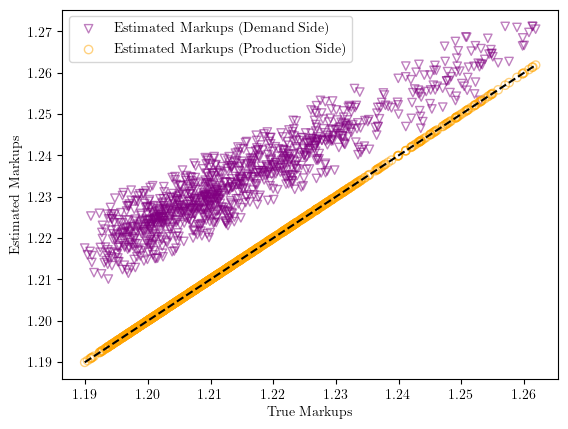

In [42]:
# For figure 0 value of the markups with the esitmated parameters at the true shocks
true_markups = model_true.markups.flatten()
estimated_markups_demand_side = estimated_markups
# markups under the assumption of exact product price knowledge
estimated_markups_production_side = (theta_l_hat * model_true.prices.flatten()*
                                     model_true.market_shares.flatten()
                                     *n_consumers)/( wage_hat* model_true.labor_quantity.flatten())

# Create the scatter plot
plt.scatter(true_markups, estimated_markups_demand_side, 
            color='purple',
              label='Estimated Markups (Demand Side)', marker='v',
               alpha=0.5, facecolors='none', edgecolors='purple')
plt.scatter(true_markups, estimated_markups_production_side,
             color='orange',
               label='Estimated Markups (Production Side)', marker='o',
                alpha=0.5, facecolors='none', edgecolors='orange')

plt.plot([min(true_markups), max(true_markups)], [min(true_markups), max(true_markups)], color='black', linestyle='--')

# Set the labels and title
plt.xlabel('True Markups')
plt.ylabel('Estimated Markups')

# Add a legend
plt.legend()

# Display the plot
plt.show()